## Inverted Pendulum Control

### Joseph Leung

<p>Normally when a pendulum is dropped and let go, it will find itself eventually stopping vertically downward. The goal of this project is to balance a pendulum on a cart so that it stays vertically upright at 180 degrees. To balance the pendulum, the cart will move back and forth.<p>
    
Our states will be:<p>
$$
\begin{bmatrix}
x\\
\dot{x}\\
\theta\\
\dot{\theta}
\end{bmatrix} = 
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4\\
\end{bmatrix}$$
And the model of the pendulum and cart is: $$\dot{x_1}= x_2 $$ <p>
$$\dot{x_2}=\frac{(-m^2L^2gC_yS_y + mL^2(mLx_4^2S_y - dx_2))}{D} + \frac{mL^2u}{D} $$ <p>
$${\dot{x_3}}= x_4 $$ <p>
$$\dot{x_4}=\frac{(mgLS_y(m+M) - mLC_y(mLx_4^2S_y - dx_2))}{D} - \frac{mLC_yu}{D} $$
where:</p><br>
$D= mL^2(M+m)sin^2(\theta)$<p>
$S_y= sin(\theta)$<p>
$C_y= cos(\theta)$

First we will start by initializing the properties of the cart, which are in SI units,  
where m is the mass of the ball at the end of the cart,  
M is the mass of the cart,  
L is the length of the pole,  
g is the gravitational constant,  
d is the drag constant, and  
s is -1 pr 1 whether the cart is going to be stabilized around $\theta = 0 \ or \ \pi$

In [114]:
clc
close all
clear all

m = 1;
M = 5;
L = 2;
g = -10;
d = 1;
s = 1; %pendulum up

Now we will form the dynamics to be in the state space form of $$\dot{x}=Ax+ Bu $$ <p>
$$ y= Cx $$
where it has been linearized around 
$$X_d =\begin{bmatrix}
0 \\  0 \\ \pi \\ 0 \\
\end{bmatrix}$$  <p>

We are going to be using the seperation principle to have our observer and controller working at the same time so we need to check the controllability and observability of the system. This is Linear Quadratic Gaussian control, which is a control scheme that uses Linear Quadratic Regulator (LQR) for control and kalman filter for estimation. Since we are using LQR our control will be $u = -Kx$ .

In [115]:
A = [0 1 0 0; 
    0 -d/M -m*g/M 0;
    0 0 0 1;
    0 -s*d/(M*L) -s*(m+M)*g/(M*L) 0];

B = [0; 1/M; 0; s*1/(M*L)];

C=[1 0 0 0; 
    0 0 1 0];

rank(ctrb(A,B));
rank(obsv(A,C));

t_f = 15;
dt = 0.001;
t = 0:dt:t_f; 

x(:,1)=[-3; 0; pi + .1; .5]; %initial conditions
Y(:,1)=C*x;

Here we design a LQR controller for the pendulum picking values of Q and R. When picking values of Q and R if the states matter more we want the   
norm(Q) >> norm(R). Here I do want the states to matter more since balancing the pendulum is the goal of the project, which is why for the third value in the Q matrix one value is priortized over the others. I do not want too low a value for R just cause I want the animation to run longer to show the motion of the cart.

In [116]:
%Controller
N=length(t);
Q =  diag([.5 .5  10 .5]);
R = .2; 
P = care(A,B,Q,R);
K = inv(R)*B'*P; 

Here we design an observer with the continuous time Kalman filter using MATLAB’s care command. Here we also initialize our estimates. Here Q_k and R_k work similarly to Q and R for the LQR controller. The Q_k is the disturbance in states and R_k is the measurement noise. Here we will trust our states more since the mesurement noise is so high. 

In [117]:
%Observer
Q_k = diag([.1 .1 .1 .1]); % The disturbance in states
R_k = diag([.5 .5 ]); %measurement noise
P_k = care(A',C',Q_k,R_k);
K_k = P_k*C'*inv(R_k);
LL = K_k;

X_hat(:,1) = [-2.5; 0; pi+.15 ; .5];
y_hat(:,1) = C*X_hat;

Here we iterate over time and discretize our system to get our system at the desired states of:

$$x_f =\begin{bmatrix}
1 \\  0 \\ \pi \\ 0 \\
\end{bmatrix}$$  <p>

In [118]:
for i= 2:N
    u = -K*(X_hat(:,i-1)-[1; 0; pi; 0]);
    
Sy = sin(x(3,i-1));
Cy = cos(x(3,i-1));
D = m*L*L*(M+m*(1-Cy^2));

dy(1,1) = x(2,i-1) ;
dy(2,1) = (1/D)*(-m^2*L^2*g*Cy*Sy + m*L^2*(m*L*x(4,i-1)^2*Sy - d*x(2,i-1))) + m*L*L*(1/D)*u ;
dy(3,1) = x(4,i-1);
dy(4,1) = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*x(4,i-1)^2*Sy - d*x(2,i-1))) - m*L*Cy*(1/D)*u ;

dy=dy+[.1;.1;.1;.1]*randn;

x(:,i)=x(:,i-1)+dy*dt;
Y(:,i)=C*x(:,i); %+ sqrt(R_k)*randn(2,1);

Sy_h = sin(X_hat(3,i-1));
Cy_h = cos(X_hat(3,i-1));
D_h = m*L*L*(M+m*(1-Cy_h^2));

dy_hat(1,1) = X_hat(2,i-1);
dy_hat(2,1) = (1/D_h)*(-m^2*L^2*g*Cy_h*Sy_h + m*L^2*(m*L*X_hat(4,i-1)^2*Sy_h - d*X_hat(2,i-1))) + m*L*L*(1/D_h)*u;
dy_hat(3,1) = X_hat(4,i-1);
dy_hat(4,1) = (1/D_h)*((m+M)*m*g*L*Sy_h - m*L*Cy_h*(m*L*X_hat(4,i-1)^2*Sy_h - d*X_hat(2,i-1))) - m*L*Cy_h*(1/D_h)*u +.01*randn;

X_hat(:,i)=X_hat(:,i-1)+dt*(dy_hat + LL*(Y(:,i-1)-y_hat(:,i-1)));
y_hat(:,i)=C*X_hat(:,i);

end


__Here the plots shows that the two main states: Resulting in the position of the cart and theta at the desired values.__  
As for the position it does seem to swing very heavily to -10 and then jerk back over the desired position which could mean that I could change the value of R to penalize the control more.

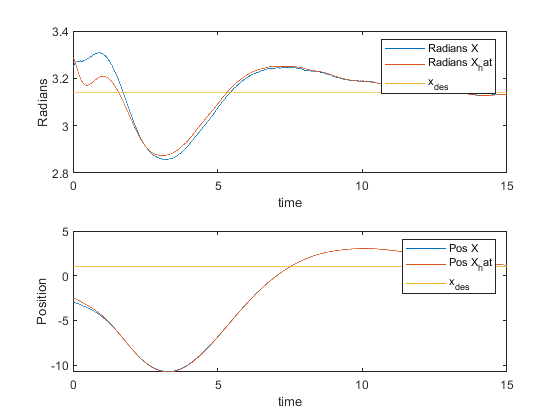

In [119]:
figure;
subplot(2,1,1)
plot(t,x(3,:),t,X_hat(3,:),t,pi*ones(size(t)));
legend('Radians X','Radians X_hat','x_{des}')
ylabel('Radians')
xlabel('time')
subplot(2,1,2)
plot(t,x(1,:),t,X_hat(1,:),t,ones(size(t)));
legend('Pos X','Pos X_hat','x_{des}')
ylabel('Position')
xlabel('time')
